<a href="https://colab.research.google.com/github/SebastianOrmaechea/Reinforcement-Learning/blob/main/Lab2RL_G_O_V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2022



<font color='red'>Integrantes:


<font color='red'> * Garay, Carolina del Valle

<font color='red'> * Ormaechea, Sebastián Gabriel

<font color='red'> * Venchiarutti, Gustavo


# Introducción

Créditos:

* Documentación y repo de Stable-baselines https://stable-baselines3.readthedocs.io.
    * Tutorial sobre SB3: https://github.com/araffin/rl-tutorial-jnrr19.
* Documentación y repo de OpenAI Gym https://github.com/openai/gym/blob/master/docs/.
    * Crear un entorno https://github.com/openai/gym/blob/master/docs/creating-environments.md. 

Stable-baselines3: framework de deep RL que provee interfaces para ejecutar y adaptar algoritmos de RL "al estilo scikit-learn". Permite utilizar agentes abstrayéndonos de los detalles de bajo nivel de abstracción referentes a la implementación del algoritmo$^1$

Además, ofrece herramientas muy útiles como

* Monitores que permiten ver el rendimiento del agente según se desempeña en el entorno, sin tener que esperar a que finalice de entrenar.
* Callbacks que permiten accionar eventos cuando se cumplen algunas condiciones en el entrenamiento de nuestro agente (por ejemplo, detenerlo si la recompensa recibida es menor a cierto umbral tras un cierto período de tiempo).


Documentación https://stable-baselines3.readthedocs.io

Es un fork activamente mantenido de [OpenAI baselines](https://github.com/openai/baselines)

La versión 3 cambia el framework subyacente de Tensorflow a Pytorch y está activamente en desarrollo; no obstante la versión 2 es completamente funcional

$^1$ no obstante, al igual que sucede generalmente con librerías de ML: 

* Siempre es bueno tener en mente las características, ventajas y desventajas del algoritmo utilizado, pues de eso depende mucho la convergencia de nuestra solución, especialmente cuando se emplean entornos adaptados para nuestras necesidades. 

* Esta librería, al igual que demás frameworks generales de RL, están muy probadas en entornos estándares de RL como Atari o PyBullet. No obstante, es posible que nuestro entorno o nuestras necesidades difieran significativamente, lo que hace que en algunos casos haya que meter mano directo en el código de los algoritmos/librería.

# Interfaz básica stable-baselines

In [ ]:
import time

### Instalación de Stable-baselines


In [ ]:
#@title Instalación (no modificar)
!pip install stable-baselines3[extra] 

Desde Windows, además, instalar: 
* Microsoft Visual C++ desde https://visualstudio.microsoft.com/visual-cpp-build-tools/
* PyType, mediante `conda install -c conda-forge pytype`

### Instalación de RLBaselinesZoo (Opcional!)

Desde Google Colab

In [ ]:
#@title Instalación de RLBaselinesZoo (no modificar)

# Estamos en Colab?

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !git clone --recursive --depth 1 https://github.com/DLR-RM/rl-baselines3-zoo
    !cd rl-baselines3-zoo/
    !apt-get install swig cmake ffmpeg
    !pip install -r /content/rl-baselines3-zoo/requirements.txt

Desde Linux, ejecutando

    git clone --recursive --depth 1 https://github.com/DLR-RM/rl-baselines3-zoo
    cd rl-baselines3-zoo/
    conda install swig
    pip install -r requirements.txt

## Ejecución de un algoritmo de RL

### Importaciones/inicializaciones

In [ ]:
import os
from subprocess import Popen, PIPE

import numpy as np
import matplotlib.pyplot as plt

import gym
from gym import spaces
#from gym.envs.registration import register

from stable_baselines3 import DQN, PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.env_util import make_vec_env

os.makedirs('logs', exist_ok=True)

cwd = os.getcwd()

%matplotlib inline
%load_ext tensorboard

### Renderización

In [ ]:
if not IN_COLAB:

    obs = env.reset()
    for i in range(1000):
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        env.render()
        if done:
          obs = env.reset()

    env.close()

#### Ver rendimiento del agente en tensorboard

In [ ]:
venv = make_vec_env(lambda: gym.make('CartPole-v1'), n_envs=1)

model = DQN('MlpPolicy', venv, tensorboard_log='tensorboard/')
model.learn(total_timesteps=100000)

Para verlo en tensorboard, correr

`tensorboard --logdir=tensorboard/`

### Monitor

Vamos a crear un monitor para loguear nuestro agente en la carpeta logs. Nuestro monitor guardará datos de recompensa (r), duración (l) y tiempo total (t)

In [ ]:
env = gym.make('CartPole-v1')
env = Monitor(env, 'logs/')  # reemplazamos env por su monitor

model = DQN('MlpPolicy', env, )
model.learn(total_timesteps=10000)

### Callbacks

In [ ]:
env = gym.make('CartPole-v1')

callbacks = []  # lista de callbacks a usar, pueden ser varios

# callback para detener entrenamiento al alcanzar recompensa de 9.8
# (es una recompensa muy baja, pero la establecemos a fines demostrativos)
#que deje de entrenar a un cierto umbral de recompensa
stop_training_callback = StopTrainingOnRewardThreshold(reward_threshold=9.8)

# al crear EvalCallback, se asocia el mismo con stop_training_callback
callbacks.append(EvalCallback(Monitor(env, 'logs/'), 
                              eval_freq=1000,
                              callback_on_new_best=stop_training_callback))

# la semilla aleatoria hace que las ejecuciones sean determinísticas
model = DQN('MlpPolicy', env, seed=42)
model.learn(total_timesteps=10000, callback=callbacks)

Eval num_timesteps=1000, episode_reward=9.60 +/- 0.80
Episode length: 9.60 +/- 0.80
New best mean reward!
Eval num_timesteps=2000, episode_reward=9.20 +/- 0.75
Episode length: 9.20 +/- 0.75
Eval num_timesteps=3000, episode_reward=9.80 +/- 0.75
Episode length: 9.80 +/- 0.75
New best mean reward!


### Ejecutar agente RL en múltiples ambientes

Esta librería provee una interfaz para ejecutar agentes en varias instancias de un mismo entorno a la vez (*vectorized environments*), de modo tal que se habilite la ejecución paralela y de otras funcionalidades útiles.

Para ello, varios de sus algoritmos implementan cambios que consideren la posibilidad de que haya múltiples entornos subyacentes, por ejemplo `step(accion)` cambia a `step(lista_acciones)`, aplicando acciones a todos los entornos, recibiendo ahora múltiples observaciones y recompensas.

Otro cambio: se aplica `reset()` automáticamente a cada entorno que llega a un estado final.

SB brinda dos formas de utilizar entornos vectorizados:

* **DummyVecEnv**, el cuál consiste en un *wrapper* de varios entornos, los cuáles funcionarán en un sólo hilo. Este wrapper es útil como entrada de algoritmos que requieren los entornos de esta forma, y habilita los procesamientos y operaciones comunes de los entornos vectorizados.
* **SubprocVecEnv**, el cuál paraleliza multiples entornos pero en procesos de ejecucíon separados. Cada proceso tiene su propia memoria y puede adquirir derechos sobre las CPUs de la computadora donde se ejecuta. Se utiliza cuando el entorno del agente es computacionalemente complejo. Atención! **Puede comer mucha RAM**.

Vemos un ejemplo:

In [ ]:
# ejemplo de ambiente dummy
venv = DummyVecEnv([lambda: gym.make('CartPole-v1')]*4)

model = PPO('MlpPolicy', venv, )
model.learn(total_timesteps=10000)

También puede hacerse con un una función de SB a tal efecto

In [ ]:
venv = make_vec_env(lambda: env, n_envs=4)

model = PPO('MlpPolicy', venv, )
model.learn(total_timesteps=10000)

### Ejecutar agente con políticas personalizadas

In [ ]:
# Creamos una clase con una red neuronal de 128x128 neuronas

model = PPO('MlpPolicy', policy_kwargs=dict(net_arch=[128,128]), env='CartPole-v1', verbose=1)
model.learn(total_timesteps=10000)

Using cpu device
Creating environment from the given name 'CartPole-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 20.6     |
| time/              |          |
|    fps             | 1266     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.4        |
|    ep_rew_mean          | 25.4        |
| time/                   |             |
|    fps                  | 692         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008125117 |
|    clip_fraction        | 0.0909      |
|    cl

[Buen post](https://medium.com/aureliantactics/understanding-ppo-plots-in-tensorboard-cbc3199b9ba2) en donde se explica qué significan varias de estas métricas. Para verlas en detalle podemos consultar directamente el [código fuente](https://github.com/DLR-RM/stable-baselines3/blob/master/stable_baselines3/ppo/ppo.py), que está bien documentado y no es muy difícil de seguir.

### Utilizar un entorno personalizado

Antes que nada, además de la interfaz que ya vimos de Gym, hay otras nociones que tenemos que tener en cuenta en este contexto:

* Los entornos definen un espacio de estados y de acciones, a partir de los cuáles los modelos asumen y respetan la "forma" de observaciones y acciones. Por ejemplo, algunos algoritmos están diseñados para espacios de acciones discretos (DQN), continuos (DDPG) o bien poseen implementaciones particulares pueden usarse en ambos (PPO, en el repo de SB3). En cuanto a los espacios, algunos algoritmos asumen explícitamente un espacio discreto (y pequeño), como Q-Learning, mientras que otros como PPO asumen cualquier tipo de espacio.
* Los dos tipos más comunes de estados o acciones son los espacios discretos `gym.spaces.Discrete` y los continuos `gym.spaces.Box`.
* Los espacios discretos definen un conjunto de $n$ estados/acciones $\{ 0, 1, \dots, n-1 \}$, mientras que los espacios continuos definen un espacio $\mathbb{R}^d$, de una de las siguientes 4 formas: $[a, b], (-\infty, b], [a, \infty), (-\infty, \infty)$, en donde $a,b$ son las cotas superior e inferior (de existir).
* Ejemplos: un espacio de acciones `Discrete(4)` tiene 4 acciones: $\{0,1,2,3\}$; un espacio de estados `Discrete(16)` tiene 16 estados. Un espacio de estados ALTURA, ANCHO, N_CANALES que represente una imagen RGB acotada en $[a=0, b=255]$ se puede crear como

`observation_space = spaces.Box(low=0, high=255, shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)`

Para usar un entorno compatible por esta librería, el mismo tiene que heredar de *gym.Env*. Vemos un ejemplo (crédito: Antonin Raffin https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)

In [ ]:
class GoLeftEnv(gym.Env):
  #clase heredada de los ambientes de gym
  """
  Ambiente personalizado que sigue la interfaz de gym.
  Es un entorno simple en el cuál el agente debe aprender a ir siempre 
  hacia la izquierda.
  """
  # Dado que podemos estar en colab, no podemos implementar la salida por interfaz 
  # gráfica ('human' render mode) 
  metadata = {'render.modes': ['console']}
  # Definimos las constantes
  LEFT = 0
  RIGHT = 1

  def __init__(self, grid_size=10):
    super(GoLeftEnv, self).__init__()

    # Tamaño de la grilla de 1D
    self.grid_size = grid_size
    # Inicializamos en agente a la derecha de la grilla
    self.agent_pos = grid_size - 1

    # Definimos el espacio de acción y observaciones
    # Los mismos deben ser objetos gym.spaces
    # En este ejemplo usamos dos acciones discretas: izquierda y derecha
    n_actions = 2
    self.action_space = spaces.Discrete(n_actions)
    # La observación será la coordenada donde se encuentra el agente
    # puede ser descrita tanto por los espacios Discrete como Box
    self.observation_space = spaces.Box(low=0, high=self.grid_size,
                                        shape=(2,), dtype=np.float32)

  def reset(self):
    """
    Importante: la observación devuelta debe ser un array de numpy
    :return: (np.array) 
    """
    # Se inicializa el agente a la derecha de la grilla
    self.agent_pos = self.grid_size - 1
    # convertimos con astype a float32 (numpy) para hacer más general el agente
    # (en caso de que querramos usar acciones continuas)
    return np.array([self.agent_pos]).astype(np.float32)

  def step(self, action):
    if action == self.LEFT:
      self.agent_pos -= 1
    elif action == self.RIGHT:
      self.agent_pos += 1
    else:
      raise ValueError("Se recibió una acción inválida={} que no es parte del espacio de acciones".format(action))

    # Evitamos que el agente se salga de los límites de la grilla
    self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size)

    # Llegó el agente a su estado objetivo (izquierda) de la grilla?
    done = bool(self.agent_pos == 0)

    # Asignamos recompensa sólo cuando el agente llega a su objetivo
    # (recompensa = 0 en todos los demás estados)
    reward = 1 if self.agent_pos == 0 else 0

    # gym también nos permite devolver información adicional, ej. en Atari: 
    # las vidas restantes del agente (no usaremos esto por ahora)
    info = {}

    return np.array([self.agent_pos]).astype(np.float32), reward, done, info

  def render(self, mode='console'):
    if mode != 'console':
      raise NotImplementedError()
    # en nuestra interfaz de consola, representamos el agente como una cruz, y 
    # el resto como un punto
    print("." * self.agent_pos, end="")
    print("x", end="")
    print("." * (self.grid_size - self.agent_pos))

  def close(self):
    pass

In [ ]:
env = GoLeftEnv(grid_size=10)
env = make_vec_env(lambda: env, n_envs=1)

model = DQN('MlpPolicy', env, verbose=1).learn(20000)

Using cpu device
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 114      |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.783    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 8553     |
|    time_elapsed     | 0        |
|    total_timesteps  | 457      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 134      |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.491    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9085     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1071     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 110      |
|    ep_rew_mean      | 1        |
|    exploration_rate | 0.372    |
| time/               |          |
|  

Ver agente entrenado

In [ ]:
obs = env.reset()
for i in range(10):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render(mode='console')
    if dones[0]:
        obs = env.reset()

........x..
.......x...
......x....
.....x.....
....x......
...x.......
..x........
.x.........
.........x.
........x..


## Normalización de features y recompensas

Stable-Baselines3 tiene predefinidos un conjunto de **wrappers** genericos que pueden utilizarse para preprocesar las observaciones que llegan al agente RL, desacoplando del mismo el prepocesamiento.

Entre las funcionalidades disponibles tenemos:
* **VecFrameStack**: Se utiliza cuando la observación que percibe el agente es una imagen. Sirve para expandir el espacio de estados apilando N frames de manera conjunta (ver [paper de DQN](https://arxiv.org/abs/1312.5602) para más detalle).
* **VecNormalize**: Se utiliza para normalizar las observaciónes y/o las recompenzas que percibe el agente, a $\mu=0$ y $\sigma=1$. También permite cortar valores de observaciones y/o recompensas que excedan un rango establecido. 
* **VecCheckNan**: Se utiliza para trackear los estados del entorno que generan que los gradientes de la RNN se hagan NaN.
* **VecVideoRecorder**: Se utiliza para exportar el funcionamiento de la política aprendida por el agente a un video (MP4).

Ademas, se pueden crear **wrappers** personalizados extendiendo la clase **VecEnvWrapper**:

```
class MiWrapper(VecEnvWrapper):
    [...]
```
### Ejemplo (VecNormalize)

In [ ]:
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

env = gym.make('CartPole-v1')
env = DummyVecEnv([lambda: env])  # Multiples entornos vectorizados
# Normalizamos tanto observaciones como recompensas, y recortamos ambas cuando exceden 10
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.0, clip_reward=10.0)

model = DQN('MlpPolicy', env)
model.learn(total_timesteps=10000)


# RL-baselines3-zoo

Colección de agentes RL y herramientas útiles para ejecutarlos, evaluarlos e incluso hacer videos con ellos. Los agentes de este repo están preparados con la configuración requerida para los distintos tipos de entornos, incluyendo Atari, PyBullet y entornos clásicos, incluyendo configuraciones e híper-parámetros que producen buenas políticas para tales entornos.

Esta librería ofrece un muy buen punto de partida para utilizar agentes / entornos personalizados, ya que ofrece una [interfaz](https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/train.py) fácilmente adaptable a nuestras necesidades.

Si se usan entornos personalizados con rl-baselines3-zoo, debe tenerse en cuenta que se deben definir todos los híper-parámetros de antemano, sea al instanciar el agente, o en la carpeta */rl-baselines3-zoo/hyperparams*; de lo contrario arrojará error por no encontrar qué híper-parámetro usar.

**Importante:** esta librería es enteramente opcional, no es necesaria para realizar los labs.

In [ ]:
# verificamos si está el repo rl-baselines3-zoo, si es así ejecutamos las celdas siguientes
repo_downloaded = os.path.exists('rl-baselines3-zoo')

## Ejecución

Los agentes pueden ser llamados desde la consola mediante comandos como

`python train.py --algo algo_name --env env_id`

Los cuales pueden ser llamados usando

In [ ]:
if repo_downloaded:

    os.chdir('rl-baselines3-zoo/')

    args = [
        '-n', str(100000),
        '--algo', 'ppo',
        '--env', 'CartPole-v1'
    ]

    p = Popen(['python', 'train.py'] + args,
                                   stdin=PIPE, stdout=PIPE, stderr=PIPE)
    output, err = p.communicate()
    rc = p.returncode
    os.chdir(cwd)
    assert rc == 0

Ver en acción el agente entrenado (nota: no disponible en Google Colab, requiere ffmpeg)

In [ ]:
if not IN_COLAB and repo_downloaded:
    os.chdir('rl-baselines3-zoo/')

    args = [
        '--algo', 'ppo',
        '--env', 'CartPole-v1',
        '--folder', 'logs/'
    ]

    p = Popen(['python', 'enjoy.py'] + args,
                                   stdin=PIPE, stdout=PIPE, stderr=PIPE)
    output, err = p.communicate()
    rc = p.returncode
    os.chdir(cwd)
    assert rc == 0

También es posible grabar un video! Ver https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#record-a-video

Ver curva de aprendizaje obtenida por el agente desde *utils.plot*

In [ ]:
os.chdir('rl-baselines3-zoo/')

args = [
    '--algo', 'ppo',
    '--env', 'CartPole-v1',
    '--exp-folder', 'logs/'
]

p = Popen(['python', '-m', 'scripts.plot_train'] + args, stdout=PIPE)
output, err = p.communicate()
rc = p.returncode
os.chdir(cwd)

assert rc == 0

In [ ]:
print(output)

b'Figure(640x480)\n'


## Híper-parámetros

rl-baselines-zoo provee híper-parámetros que resultan en curvas de aprendizaje que convergen en buena cantidad de entornos. Estos híper-parámetros pueden verse en cada uno de los archivos YAML de cada algoritmo, [acá](https://github.com/DLR-RM/rl-baselines3-zoo/tree/master/hyperparams).

También provee funcionalidad para optimizar los híper-parámetros con la librería [Optuna]( https://github.com/optuna/optuna). En los mismos se incluyen rangos de híper-parámetros que se usaron para optimizar entornos como los de PyBullet, y son fácilmente modificables para adaptarlo a nuestros propios entornos. Para ver cómo se llama a la interfaz de Optuna ver [este código](https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/utils/hyperparams_opt.py).

Nota: **Optuna come muchos recursos!**

# Entrenando otros agentes

### Algunos conjuntos de entornos

CartPole es una excelente línea base (de hecho suele ser la prueba preliminar de todo nuevo algoritmo), porque tiene recompensas constantes pero requiere cierta solidez por parte del algoritmo para hacerlo converger al óptimo.

No obstante, al implementar un algoritmo, es deseable que el mismo pueda desenvolverse de forma consistente en varios grupos de entornos. A continuación va una lista con varios entornos que sirven como prueba:

| Entornos                                                                                                           | Estados            | Acciones            | Dificultad      | Implementado por                                                                                                                                                            |
|--------------------------------------------------------------------------------------------------------------------|--------------------|---------------------|-----------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Clásicos (CartPole, MountainCar, Pendulum, Deep sea (testea exploración), umbrella (testea asignación de crédito)) | Discretos/Continuos          | Continuas/discretas | Baja/Media      | [Gym](https://github.com/openai/gym/wiki/Table-of-environments) y [BSuite](https://github.com/deepmind/bsuite)                                                                                                                          |
| Grilla (desde pequeñas donde hay que salir hasta grandes con muchas habitaciones y subproblemas)                   | Discretos/imágenes | Discretas           | Baja/Media/Alta | [gym-minigrid](https://github.com/maximecb/gym-minigrid)                                                                                                                    |
| Grilla/plataforma/estilo Atari, generados proceduralmente                                                          | Imágenes           | Discretas           | Media/Alta      | [Gym](https://github.com/openai/procgen)                                                                                                                                    |
| Plataforma 2D, como LunarLander o BipedalWalker                                                                    | Continuos          | Continuas/discretas | Media/Alta      | [Gym](https://github.com/openai/gym/wiki/Table-of-environments)                                                                                                                                                                         |
| Primera persona en 3D                                                                                              | Imágenes           | Continuas/discretas | Media/Alta      | [Deepmind](https://github.com/deepmind/lab)                                                                                                                                 |
| Simulación física de pequeños robots                                                                               | Continuos          | Continuas           | Media/Alta      | Gym (con el motor [MuJoCo](https://mujoco.org/) o [PyBullet](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit#heading=h.wz5to0x8kqmr)) |
| Atari                                                                                                              | Continuos          | Discretas           | Media/Alta      | [Gym](https://github.com/openai/gym/wiki/Table-of-environments) (son todos aquellos entornos que terminan en "*-v4*"                                                                                                                                                                         |


## Resumen de algunos algoritmos

Se resumen ahora varios algoritmos del estado del arte de aprendizaje por refuerzos profundo



| Algoritmo | Tipo       | Espacio de acciones | Resumen rápido                                                                                                                                                | Artículo                         |
|-----------|------------|---------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------|
| DQN       | Off-policy | Discretas           | Extiende Q-Learning a deep learning. En Stable-baselines, DQN incluye todas las mejoras ya incorporadas.                                                      | https://arxiv.org/abs/1312.5602  |
| ACER      | Off-policy | Discretas           | Combina una arquitectura actor-critic con un buffer y repetición de experiencia.                                                                              | https://arxiv.org/abs/1611.01224 |
| A3C       | On-policy  | Ambos               | Múltiples agentes corriendo en múltiples instancias del ambiente, acumulando sus gradientes y actualizándolos tras un cierto tiempo.                          | https://arxiv.org/abs/1602.01783 |
| PPO       | On-policy  | Ambos               | Punta de lanza de policy gradient, incluye mecanismo para que el gradiente actualice de forma acotada, mejorando drásticamente la estabilidad.             | https://arxiv.org/abs/1707.06347 |
| DDPG      | Off-policy | Continuas           | Como en espacios de acciones continuos es muy difícil encontrar $\max_a Q(s,a)$, se aproxima via $Q(s, a(s \mid \theta_a))$, siendo $a$ un actor estocástico. | https://arxiv.org/abs/1509.02971 |
| TD3       | Off-policy | Continuas           | Mejora DDPG utilizando dos funciones $Q$ y retrasando la actualización para reducir la sobreestimación de $Q$.                                                | https://arxiv.org/abs/1802.09477 |
| SAC       | Off-policy | Continuas           | Usa dos funciones $Q$, introduce el bonus por entropía y usa un actor estocástico que muestrea acciones según una política $\pi$.                             | https://arxiv.org/abs/1801.01290 |

## Resumen de algunas herramientas/trucos comúnmente usados

* Experience replay/buffer de experiencia: guarda las experiencias en un buffer para poder usarlas repetidamente durante el entrenamiento.
    * Ventajas: experiencias raras pero muy relevantes (ej: que tienen mucho error de actualización) quedan guardadas en memoria, pudiendo ser usadas repetidamente para aprender sin necesidad de esperar a que se repitan.
    
    En métodos de gradiente de política, en cambio, el aprendizaje queda reflejado en los pesos, lo cuál puede hacer que un agente no se desenvuelva correctamente en entornos de recompensa escasa como MountainCar.
    
    * Desventajas: requiere considerable RAM, son usables solamente en algoritmos off-policy y su muestreo no necesariamente refleja la probabilidad real de tener esas experiencias en el entorno (añadiendo sesgo), por lo que es recomendable usarlo junto con importance sampling.
    
* Importance sampling: aplica un descuento a las actualizaciones a partir de experience replay relacionado a cuán probable era realizar esa transición.
* Entropía: añade un bonus a la función de recompensa para que bonifique políticas $\pi(s \mid a)$ que tengan mayor entropía que otras, motivando la exploración del agente.
* Juntar varias secuencias de imágenes. Usado principalmente en entornos de Atari para poder evaluar la dirección de movimientos.
* Normalización de recompensas/estados. Normaliza las recompensas y observaciones usualmente con una media móvil, de modo tal que las observaciones/recompensas reflejen su relación y varianza con respecto a las demás.
* Clipping (recorte) de recompensas. Se usaba principalmente en entornos de Atari con algoritmos tipo DQN para recortar el impacto que las distintas recompensas tenían, a una constante (ej: 1). Suele usarse como una cota máxima de recompensas/observaciones normalizadas.

# Lab 2

1. Crear tu propio entorno y entrenar agentes RL en el mismo. Analizar la convergencia con distintos algoritmos* (ej: PPO, DQN), resultados con distintas funciones de recompensa e híper-parámetros. 

    Algunas ideas:

    * Transformar GoLeftEnv en una grilla 2D, añadir paredes / trampas / agua.
    * Crear un entorno que juegue a algún juego como el ta-te-ti.
    * Crea un entorno totalmente nuevo que sea de tu interés!


## **Snake clásico modififcado**

Implementamos una modificación al juego de arcade clásico Snake, agregando paredes. En este juego una serpiente se mueve por un tablero y debe recoger frutas para comer. Utilizamos el algoritmo "PP0" como técnica de aprendizaje.



In [ ]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
%matplotlib inline

class Serpiente(gym.Env):
    """
    Entorno personalizado para Stable Baseline 3 para el clásico Snake 
    con modificación de paredes
    """
    metadata = {'render.modes': ['console','rgb_array']}
    #Direction constants
    n_actions = 3 #3 posibles pasos por cada turno
    LEFT = 0
    STRAIGHT = 1
    RIGHT = 2
    #Grid label constants
    EMPTY = 0
    SNAKE = 1
    WALL = 2
    FOOD = 3
    #Rewards
    REWARD_PER_STEP = 0 # recompensa por cada paso dado, entra en bucles infinitos si >0
    #Definir pasos máximos para evitar bucles infinitos
    REWARD_WALL_HIT = -20 #debe ser inferior a -REWARD_PER_STEP_TOWARDS_FOOD para evitar golpear la pared intencionalmente
    REWARD_PER_STEP_TOWARDS_FOOD = 1 #dar recompensa por moverse hacia la comida y penalización por alejarse
    REWARD_PER_FOOD = 100 
    MAX_STEPS_AFTER_FOOD = 200 #parar si pasamos demasiado tiempo sin comer para evitar bucles infinitos


    def __init__(self, grid_size=6):
        super(Serpiente, self).__init__()
        #Pasos
        self.stepnum = 0; self.last_food_step=0
        # Tamaño de la cuadrícula 2D (incluidas las paredes)
        self.grid_size = grid_size
        # Inicializar la serpiente
        self.snake_coordinates = [ (1,1), (2,1) ] #comenzar en la esquina inferior izquierda
        #Inicializar la grilla
        self.grid = np.zeros( (self.grid_size, self.grid_size) ,dtype=np.uint8) + self.EMPTY
        self.grid[0,:] = self.WALL; self.grid[:,0] = self.WALL; #pared en los bordes
        self.grid[int(grid_size/2),3:(grid_size-3)] = self.WALL; #pared interior 
        self.grid[self.grid_size-1,:] = self.WALL; self.grid[:,self.grid_size-1] = self.WALL
        for coord in self.snake_coordinates:
            self.grid[ coord ] = self.SNAKE  #poner serpiente en la grilla
        self.grid[2,2] = self.FOOD  #comenzar en la esquina superior derecha
        #Distancia inicial a la comida
        self.head_dist_to_food = self.grid_distance(self.snake_coordinates[-1],np.argwhere(self.grid==self.FOOD)[0] )
        #Almacenar valores iniciales
        self.init_grid = self.grid.copy()
        self.init_snake_coordinates = self.snake_coordinates.copy()
        
        # El espacio de acción
        self.action_space = spaces.Discrete(self.n_actions)
        # El espacio de observación, "posición" son las coordenadas de la cabeza; "dirección" es hacia dónde se
        #dirige la serpiente,"cuadrícula" contiene la información completa de la cuadrícula
        self.observation_space = gym.spaces.Dict(
            spaces={
                "position": gym.spaces.Box(low=0, high=(self.grid_size-1), shape=(2,), dtype=np.int32),
                "direction": gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.int32),
                "grid": gym.spaces.Box(low = 0, high = 3, shape = (self.grid_size, self.grid_size), dtype=np.uint8),
            })
    
    def grid_distance(self,pos1,pos2):
        return np.linalg.norm(np.array(pos1,dtype=np.float32)-np.array(pos2,dtype=np.float32))

    def reset(self):
        # Restablecer posiciones iniciales
        self.stepnum = 0; self.last_food_step=0
        self.grid = self.init_grid.copy()
        self.snake_coordinates = self.init_snake_coordinates.copy()
        #Distancia inicial a la comida
        self.head_dist_to_food = self.grid_distance(self.snake_coordinates[-1],np.argwhere(self.grid==self.FOOD)[0] )
        return self._get_obs()    
             
    def _get_obs(self):
            direction = np.array(self.snake_coordinates[-1]) - np.array(self.snake_coordinates[-2])
            #devolver la observación en el formato de self.observation_space
            return {"position": np.array(self.snake_coordinates[-1],dtype=np.int32),
                    "direction" : direction.astype(np.int32),
                    "grid": self.grid}                  
            
    def step(self, action):
        #Obtener dirección para la serpiente
        direction = np.array(self.snake_coordinates[-1]) - np.array(self.snake_coordinates[-2])
        if action == self.STRAIGHT:
            step = direction #da un paso en la dirección a la que mira la serpiente
        elif action == self.RIGHT:
            step = np.array( [direction[1], -direction[0]] )  #Girar a la derecha
        elif action == self.LEFT:
            step = np.array( [-direction[1], direction[0]] )   #Girar a la izquierda
        else:
            raise ValueError("Se recibió una acción inválida={} que no es parte del espacio de acciones".format(action))
        #New head coordinate
        new_coord = (np.array(self.snake_coordinates[-1]) + step).astype(np.int32)
        #grow snake     
        self.snake_coordinates.append( (new_coord[0],new_coord[1]) ) #convert to tuple so we can use it to index

        
        #Check what is at the new position
        new_pos = self.snake_coordinates[-1]
        new_pos_type = self.grid[new_pos]
        self.grid[new_pos] = self.SNAKE #this position is now occupied by the snake
        done = False; reward = 0 #by default the game goes on and no reward   
        if new_pos_type == self.FOOD:
            reward += self.REWARD_PER_FOOD
            self.last_food_step = self.stepnum
            #Put down a new food item
            empty_tiles = np.argwhere(self.grid==self.EMPTY)
            if len(empty_tiles):
                new_food_pos=empty_tiles[np.random.randint(0,len(empty_tiles))]
                self.grid[new_food_pos[0],new_food_pos[1]] = self.FOOD
            else:
                done = True #no more tiles to put the food to
        else:
            #If no food was eaten we remove the end of the snake (i.e., moving not growing)
            self.grid[ self.snake_coordinates[0] ] = self.EMPTY
            self.snake_coordinates = self.snake_coordinates[1:]
            if  (new_pos_type == self.WALL) or (new_pos_type == self.SNAKE):
                done = True #stop if we hit the wall or the snake
                reward += self.REWARD_WALL_HIT #penalty for hitting walls/tail
#             else:
#                 reward += self.REWARD_PER_STEP
                
        #Update distance to food and reward if closer
        head_dist_to_food_prev = self.head_dist_to_food
        self.head_dist_to_food = self.grid_distance( self.snake_coordinates[-1],np.argwhere(self.grid==self.FOOD)[0] )
        if head_dist_to_food_prev > self.head_dist_to_food:
            reward += self.REWARD_PER_STEP_TOWARDS_FOOD #reward for getting closer to food
        elif head_dist_to_food_prev < self.head_dist_to_food:
            reward -= self.REWARD_PER_STEP_TOWARDS_FOOD #penalty for getting further
        
        #Stop if we played too long without getting food
        if ( (self.stepnum - self.last_food_step) > self.MAX_STEPS_AFTER_FOOD ): 
            done = True    
        self.stepnum += 1

        return  self._get_obs(), reward, done, {}

    def render(self, mode='rgb_array'):
        if mode == 'console':
            print(self.grid)
        elif mode == 'rgb_array':
            return self.snake_plot()
        else:
            raise NotImplementedError()

    def close(self):
        pass
    
    def snake_plot(self, plot_inline=False):
        wall_ind = (self.grid==self.WALL)
        snake_ind = (self.grid==self.SNAKE)
        food_ind = (self.grid==self.FOOD)
        #Create color array for plot, default white color
        Color_array=np.zeros((self.grid_size,self.grid_size,3),dtype=np.uint8)+255 #default white
        Color_array[wall_ind,:]= np.array([0,0,0]) #black walls
        Color_array[snake_ind,:]= np.array([0,0,255]) #bluish snake
        Color_array[food_ind,:]= np.array([0,255,0]) #green food  
        #plot
        if plot_inline:
            fig=plt.figure()
            plt.axis('off')
            plt.imshow(Color_array, interpolation='nearest')
            plt.show()
        return Color_array


    

### Probamos el entorno

Utilizamos el algoritmo PPO (Proximal Policy Optimization), este tiene como objetivo mejorar la política actual del agente "Serpiente" de manera que maximice la recompensa obtenida. Para lograr esto, el algoritmo PPO utiliza una función de pérdida que tiene en cuenta tanto la recompensa obtenida por la política actual como el cambio en la misma relación con la política anterior.



In [ ]:
env = Serpiente()
env = make_vec_env(lambda: env, n_envs=1)

model = PPO('MultiInputPolicy', env, verbose=1).learn(20000)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3.88     |
|    ep_rew_mean     | 33.1     |
| time/              |          |
|    fps             | 1019     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.5         |
|    ep_rew_mean          | 54          |
| time/                   |             |
|    fps                  | 763         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.020654608 |
|    clip_fraction        | 0.356       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.08       |
|    explained_variance   | 0.000635    |
|    learning

Step 1
position= [2 2] direction= [0 1]
reward= 99 done= False
Step 2
position= [1 2] direction= [-1  0]
reward= 1 done= False
Step 3
position= [1 1] direction= [ 0 -1]
reward= -1 done= False
Step 4
position= [2 1] direction= [1 0]
reward= -1 done= False
Step 5
position= [2 2] direction= [0 1]
reward= 1 done= False
Step 6
position= [1 2] direction= [-1  0]
reward= 1 done= False
Step 7
position= [1 1] direction= [ 0 -1]
reward= -1 done= False
Step 8
position= [2 1] direction= [1 0]
reward= -1 done= False
Step 9
position= [2 2] direction= [0 1]
reward= 1 done= False
Step 10
position= [1 2] direction= [-1  0]
reward= 1 done= False
Step 11
position= [1 1] direction= [ 0 -1]
reward= -1 done= False
Step 12
position= [2 1] direction= [1 0]
reward= -1 done= False
Step 13
position= [2 2] direction= [0 1]
reward= 1 done= False
Step 14
position= [1 2] direction= [-1  0]
reward= 1 done= False
Step 15
position= [1 1] direction= [ 0 -1]
reward= -1 done= False


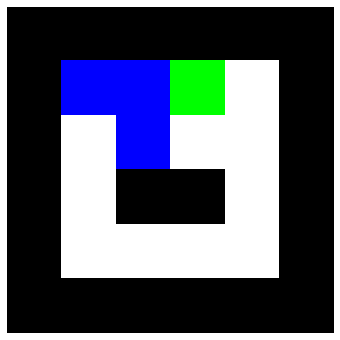

In [ ]:
##Manual testing
import matplotlib.animation as animation
from time import sleep

env = Snake_game()
env.reset()

 #Image for initial state
fig, ax = plt.subplots(figsize=(6,6))
plt.imshow(env.render(mode='rgb_array'))
plt.axis('off')
plt.savefig("snake_init.png",dpi=150)

 #Framework to save animgif
frames = []
fps=24

n_steps =15
for step in range(n_steps):
  print("Step {}".format(step + 1))

  obs, reward, done, info = env.step(0)
  print('position=', obs['position'], 'direction=', obs['direction'])
  print('reward=', reward, 'done=', done)
  frames.append([ax.imshow(env.render(mode='rgb_array'), animated=True)])
  if done:
        print("Game over!", "reward=", reward)
        break


2. Entrena agentes en entornos más complejos con stable-baselines/rl-baselines-zoo. Tener en cuenta:

    * Google Colab tiene una limitante en cuanto a cantidad de recursos de CPU/GPU (incluido un "rendimiento decreciente silencioso"), lo cuál reduce la capacidad de entrenar distintos entornos.
    * Si el entorno no está implementado en stable-baselines, debe hacerse un wrapper a mano, lo que puede ser sencillo o puede llevar algo más de trabajo, teniendo que tocar código subyacente de la librería. 

\* pueden ser usando los agentes de stable-baselines, de rl-baselines-zoo, o bien utilizando algún otro algoritmo (incluso tabular)

## **Agente LunarLander**

Entrenamos el agente LunarLander con el objetivo de controlar una nave espacial para aterrizarla de manera segura en la superficie lunar.
El agente toma decisiones sobre qué acciones ejecutar en cada momento. Esto implica evaluar el estado actual de la simulación y seleccionar la acción que maximice la recompensa esperada en el futuro. A medida que el agente experimenta y juega el juego repetidamente, debería ser capaz de aprender a aterrizar la nave de manera más eficiente y segura.



### Configuramos entorno y algoritmo DQN.

In [ ]:
!sudo apt-get update > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install rarfile --quiet
!pip install stable-baselines3[extra] ale-py==0.7.4 --quiet
!pip install box2d-py --quiet
!pip install gym pyvirtualdisplay --quiet
!pip install pyglet --quiet


In [ ]:
# Importamos librerías necesarias
import io
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gym
from gym import spaces
from gym.wrappers import Monitor

In [ ]:
nn_layers = [64,64] #configuración de la red neuronal.

learning_rate = 0.001 ##Tamaño de paso con el que se realiza el descenso por gradiente.

In [ ]:
# Crea el entorno del agente
env = gym.make('LunarLander-v2')


# Crea una carpeta temporal donde se almacenarán los archivos de registro del entrenamiento del agente
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

# Inicia la grabación del video
#env.start_video_recorder('video.mp4', (800, 600))

callback = EvalCallback(env,log_path = log_dir, deterministic=True) #Para evaluar periódicamente el desempeño del agente y registrar los resultados.
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)
model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=1,  #por simplicidad no hacemos actualizaciones por lotes.
            buffer_size=1, #tamaño de la experiencia del búfer de reproducción. 
            #Establecido en 1 ya que la actualización por lotes no se realiza
            learning_starts=1, #comienzo de aprendizaje 
            gamma=0.99, #factor de descuento (entre 0 y 1)
            tau = 1,  #coeficiente de actualización
            target_update_interval=1, #actualizar la red de destino inmediatamente
            train_freq=(1,"step"), #train the network at every step.
            max_grad_norm = 10, #the maximum value for the gradient clipping
            exploration_initial_eps = 1, #valor inicial de random action probability
            exploration_fraction = 0.5, #fracción del período de entrenamiento durante el cual se reduce la tasa de exploración
            gradient_steps = 1, #número de pasos del gradiente
            seed = 1, #semilla para los generadores pseudoaleatorios
            verbose=0) #Establecer verbose en 1 para observar los registros de entrenamiento


In [ ]:
model.learn(total_timesteps=100000, log_interval=10, callback=callback)

Eval num_timesteps=10000, episode_reward=-510.91 +/- 143.09
Episode length: 103.40 +/- 26.82
New best mean reward!
Eval num_timesteps=20000, episode_reward=-87.42 +/- 21.23
Episode length: 82.00 +/- 16.94
New best mean reward!
Eval num_timesteps=30000, episode_reward=-11.44 +/- 224.79
Episode length: 662.40 +/- 299.99
New best mean reward!
Eval num_timesteps=40000, episode_reward=-175.65 +/- 13.54
Episode length: 383.00 +/- 169.33
Eval num_timesteps=50000, episode_reward=-74.26 +/- 29.01
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=60000, episode_reward=-109.14 +/- 24.77
Episode length: 472.20 +/- 191.91
Eval num_timesteps=70000, episode_reward=-11.58 +/- 22.06
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=80000, episode_reward=21.27 +/- 108.71
Episode length: 104.40 +/- 61.39
New best mean reward!
Eval num_timesteps=90000, episode_reward=-13.80 +/- 21.36
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=150.25 +/- 86.42
Episode length: 772.00 +/- 

### Ploteamos el reward para cada episodio

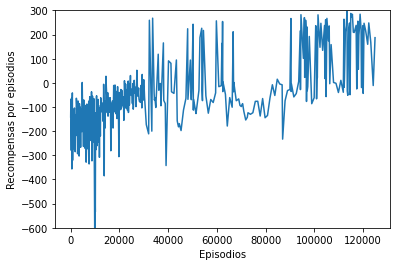

In [ ]:
x, y = ts2xy(load_results(log_dir), 'timesteps')  # Organizar los resultados registrados en un formato limpio para trazar.
plt.plot(x,y)
plt.ylim([-600, 300])
plt.xlabel('Episodios')
plt.ylabel('Recompensas por episodios');

### Visualización del rendimiento (REVISAR VIDEO)

In [ ]:
# @title Plotting/Video functions
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob
import base64

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env